# Loading and Preprocessing data for CNN

Here, for learning, we will be using the CIFAR-10 dataset  available in the TensorFlow datasets

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the CIFAR-10 dataset
(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

# Get the number of classes
num_classes = ds_info.features['label'].num_classes

print(f"Number of training examples: {ds_info.splits['train'].num_examples}")
print(f"Number of test examples: {ds_info.splits['test'].num_examples}")
print(f"Number of classes: {num_classes}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.Q8583A_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.Q8583A_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Number of training examples: 50000
Number of test examples: 10000
Number of classes: 10


## Normalizing pixel values

To improve model training, we need to normalize the pixel values to be between 0 and 1. We can do this by dividing the pixel values by 255:

In [ ]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to both training and test datasets
train_ds = train_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)

## One-hot encoding labels

While TensorFlow can work with integer labels directly, some models may require one-hot encoded labels. Here's how to apply one-hot encoding:

In [ ]:
def one_hot_encode(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), ds_info.features['label'].num_classes)

# Apply one-hot encoding to both training and test datasets
train_ds = train_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

The `tf.one_hot()` function creates a one-hot tensor for each label[7]. For CIFAR-10, this will create a 10-dimensional vector for each label, where the index corresponding to the class is set to 1 and all other indices are 0.

## Preparing the datasets for training

Finally, we can prepare the datasets for efficient training by caching the datasets, shuffling the training data, batching the datasets, and prefetching data for improved performance during training:


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Training the CNN model

## Splitting data into training and validation sets

We'll use part of the training data as a validation set to monitor our model's performance during training:

In [ ]:
# Assuming train_ds is your full training dataset
train_size = 45000
val_size = 5000

train_ds = train_ds.take(train_size)
val_ds = train_ds.skip(train_size).take(val_size)

## Setting up training parameters


In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

## Designing the model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model using model.fit()

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.3273 - loss: 1.8258 - val_accuracy: 0.5303 - val_loss: 1.3025
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5385 - loss: 1.2949 - val_accuracy: 0.5911 - val_loss: 1.1580
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6023 - loss: 1.1334 - val_accuracy: 0.6365 - val_loss: 1.0366
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6508 - loss: 1.0102 - val_accuracy: 0.6576 - val_loss: 0.9904
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6741 - loss: 0.9328 - val_accuracy: 0.6515 - val_loss: 1.0044
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6981 - loss: 0.8631 - val_accuracy: 0.6782 - val_loss: 0.9205
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7152 - loss: 0.8174 - val_accuracy: 0.6805 - val_loss: 0.9253
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7317 - loss: 0.7656 - val_accuracy: 

## Visualizing training history (accuracy and loss curves)

After training, the training history can be visualized as:

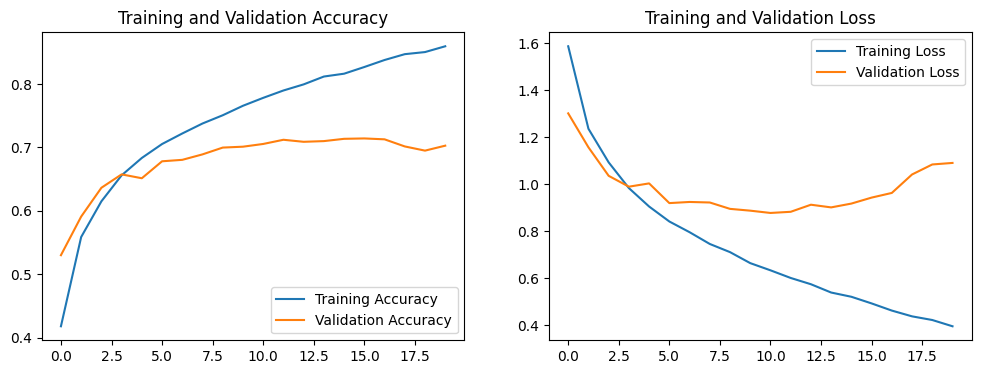

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

## Important observations from the model training




1. Training Progress:
- The model's training accuracy improves from about 54.72% in the first epoch to 87.30% by the 20th epoch.
- The training loss decreases from 1.2759 to 0.3524 over the 20 epochs.

2. Validation Performance:
- The validation accuracy improves from 57.93% to a peak of 71.79% (in epoch 15), but then declines slightly.
- The validation loss initially decreases but starts increasing after a certain point.

3. Overfitting:
- There's a clear sign of overfitting as the training continues. The training accuracy and loss continue to improve, but the validation metrics start to worsen after a certain point.
- The gap between training and validation accuracy widens significantly in later epochs.

# How to avoid overfitting?

## Data Augmentation Techniques


Data augmentation is a technique used to increase the diversity of our training set by applying random (but realistic) transformations to the existing images. This helps the model generalize better and reduces overfitting. Our augmentation function applies three transformations:

1. Random horizontal flip
2. Random brightness adjustment
3. Random contrast adjustment


For more details on these functions, refer to the TensorFlow documentation:

- [random_flip_left_right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)
- [random_brightness](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness)
- [random_contrast](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast)

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [ ]:
# Load the CIFAR-10 dataset
(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

# Normalize pixel values and one-hot encode labels
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, ds_info.features['label'].num_classes)
    return image, label

# Data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Apply preprocessing and augmentation
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (train_ds
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))

test_ds = (test_ds
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .cache()
           .prefetch(AUTOTUNE))

## Introduce dropout and L2 regularization


### Dropout

Dropout is a regularization technique where randomly selected neurons are ignored during training. This helps prevent complex co-adaptations on the training data and reduces overfitting. In our model, we use dropout after convolutional and dense layers:

```python
layers.Dropout(0.25)  # After convolutional layers
layers.Dropout(0.5)   # After dense layer
```

The argument to Dropout represents the fraction of units to drop.

[TensorFlow Dropout Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

### L2 Regularization

L2 regularization (also known as weight decay) adds a penalty term to the loss function, discouraging the weights from becoming too large. This helps in creating a simpler model that's less likely to overfit. We apply L2 regularization to the kernel weights of our convolutional and dense layers:

```python
kernel_regularizer=regularizers.l2(0.01)
```

The argument 0.01 is the regularization factor, controlling the strength of the regularization.

[TensorFlow Regularizers Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)

By combining these techniques, we aim to create a model that generalizes well to unseen data, reducing the gap between training and validation performance.

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Create the CNN model with dropout and L2 regularization
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),  # Explicitly define input shape
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

Early stopping is a technique used to prevent overfitting by halting the training process when the model's performance on the validation set stops improving. We implement this using Keras' EarlyStopping callback:

```python
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

EPOCHS = 50
```

Key components:
- `monitor='val_loss'`: We monitor the validation loss to determine when to stop training.
- `patience=5`: Training will stop if the monitored metric doesn't improve for 5 consecutive epochs.
- `restore_best_weights=True`: This ensures that we keep the model weights from the epoch with the best performance.
- `EPOCHS = 50`: We set a maximum of 50 epochs, but early stopping may end training earlier if no improvement is observed.

Early stopping helps us find the optimal point to stop training, balancing between underfitting and overfitting. It allows us to train for a potentially longer time without the risk of severe overfitting, as we'll revert to the best weights once the model's performance plateaus.

For more details, refer to the TensorFlow documentation:
[EarlyStopping Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
EPOCHS = 50  # Increased epochs, but early stopping will likely end training earlier

## Re-training the model again

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.1811 - loss: 2.5511 - val_accuracy: 0.3342 - val_loss: 1.9670
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2862 - loss: 1.9797 - val_accuracy: 0.3534 - val_loss: 1.9077
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3146 - loss: 1.9274 - val_accuracy: 0.3668 - val_loss: 1.8601
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3425 - loss: 1.8861 - val_accuracy: 0.4205 - val_loss: 1.7367
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3643 - loss: 1.8623 - val_accuracy: 0.4023 - val_loss: 1.7401
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3736 - loss: 1.8434 - val_accuracy: 0.4090 - val_loss: 1.7700
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3802 - loss: 1.8207 - val_accuracy: 0.4468 - val_loss: 1.6965
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3894 - loss: 1.8094 - val_accuracy: 

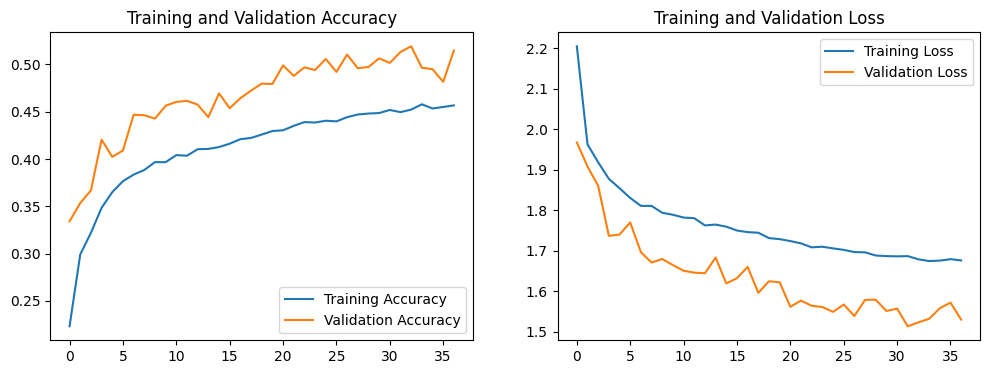

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

## Important observations from the model training

Training Progress:
- The model's training accuracy improves from 18.11% in the first epoch to 45.33% by the 37th epoch.
- The training loss decreases from 2.5511 to 1.6879 over the 37 epochs.

Validation Performance:
- The validation accuracy improves from 33.42% in the first epoch to a peak of 51.92% (in epoch 33).
- The validation loss decreases from 1.9670 to 1.5305 over the course of training.

Underfitting:
- There's a clear sign of underfitting as both training and validation accuracies remain relatively low for the CIFAR-10 dataset.
- The gap between training and validation accuracy remains small, with validation accuracy consistently higher than training accuracy.
- Both training and validation losses remain high throughout the training process, indicating the model's struggle to fit the data well.

# How to avoid underfitting?

Some of the ways that can be used to avoid underfitting are:

1. Increase Model Capacity:
- Add more convolutional layers
- Increase the number of filters in existing layers
- Add more dense layers or increase the number of neurons in existing dense layers

For more information, refer to this link:

[Keras Sequential Model Guide](https://www.tensorflow.org/guide/keras/sequential_model)
[Dense Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)



2. Reduce Regularization:
- Decrease dropout rates
- Reduce L2 regularization strength

For more information, refer to this link: [Keras Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
[Dropout Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

3. Add Batch Normalization:
- Include batch normalization layers after convolutional layers

For more information, refer to this link: [Batch Normalization Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


Let's introduce the above techniques in our previously coded model to avoid underfitting

In [ ]:
# Create the CNN model with dropout and L2 regularization
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,253,834 (12.41 MB)

 Trainable params: 3,251,018 (12.40 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Re-training the model again

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.3838 - loss: 2.9317 - val_accuracy: 0.5671 - val_loss: 1.9184
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.6586 - loss: 1.5254 - val_accuracy: 0.6918 - val_loss: 1.2941
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7292 - loss: 1.1571 - val_accuracy: 0.6593 - val_loss: 1.4002
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.7590 - loss: 1.0606 - val_accuracy: 0.7855 - val_loss: 1.0168
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7822 - loss: 1.0203 - val_accuracy: 0.7903 - val_loss: 1.0101
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8027 - loss: 0.9690 - val_accuracy: 0.7918 - val_loss: 0.9885
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8194 - loss: 0.9111 - val_accuracy: 0.7502 - val_loss: 1.1371
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8297 - loss: 0.8775 - 

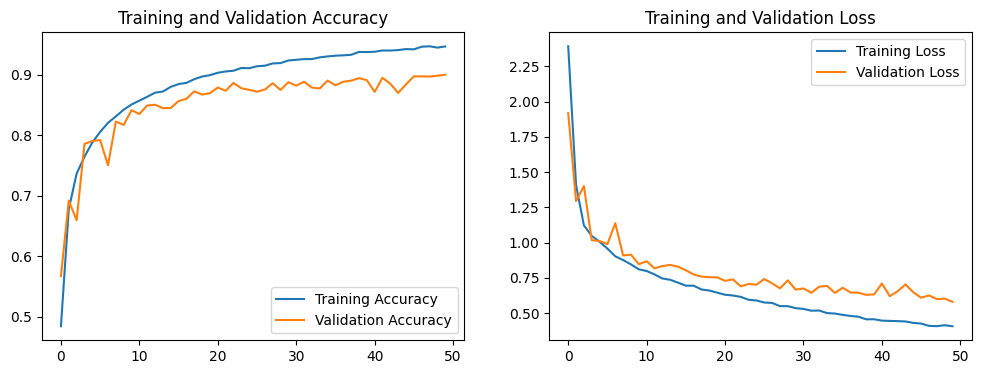

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

## Important observations from the model training

1. Rapid Initial Improvement:
   - Both training and validation accuracies improve rapidly in the first few epochs, with training accuracy increasing from 38.38% to 82.97% and validation accuracy from 56.71% to 82.23% by epoch 8.
   - This suggests that the model is learning effectively and is not underfitting.

2. Divergence Between Training and Validation Accuracy:
   - As training progresses, a gap develops between training and validation accuracies.
   - By the final epoch, training accuracy reaches 94.59% while validation accuracy is at 89.98%.
   - This growing gap is an indicator of some overfitting, as the model is performing better on the training data than on unseen validation data.

3. Plateauing of Validation Accuracy:
   - Validation accuracy shows slower improvement after about epoch 20, fluctuating between 87% and 90%.
   - Meanwhile, training accuracy continues to improve, reaching over 94%.
   - This plateauing of validation accuracy while training accuracy continues to improve is another sign of overfitting.

4. Final Performance:
   - The final test accuracy of 89.98% is good for the CIFAR-10 dataset, indicating that despite some overfitting, the model generalizes reasonably well.
   - The model is not underfitting, as both training and validation accuracies are high.

In conclusion, the model shows signs of slight to moderate overfitting, evidenced by the growing gap between training and validation accuracies and the plateauing of validation accuracy.

However, the high final test accuracy suggests that this overfitting is not severe enough to significantly compromise the model's performance on unseen data.